<a href="https://colab.research.google.com/github/hugopin/series-temporales-multivariantes/blob/master/TCC4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd # biblioteca para manipulação e análise de dados
import numpy as np # biblioteca para computação científica
import matplotlib.pyplot as plt # biblioteca para visualização de dados
df_a = pd.read_excel('dados_agrupados v3.xlsx')
df_a.info()
df_a.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5710 entries, 0 to 5709
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   data             5710 non-null   datetime64[ns]
 1   petroleo         5710 non-null   float64       
 2   ibov dolarizado  5710 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 134.0 KB


,data,petroleo,ibov dolarizado
0,1996-01-30,17.65,5247.367883
1,1996-01-31,17.76,5266.305459
2,1996-02-01,17.63,5387.934460
3,1996-02-02,17.83,5530.920885
4,1996-02-05,17.53,5451.190741


In [2]:
# Transformando a coluna data em índice
df_a.set_index('data', inplace=True)
df_a.sort_index(inplace=True)
df_a.index
df_a.head()

,petroleo,ibov dolarizado
data,,
1996-01-30,17.65,5247.367883
1996-01-31,17.76,5266.305459
1996-02-01,17.63,5387.934460
1996-02-02,17.83,5530.920885
1996-02-05,17.53,5451.190741


In [3]:
# Atribuindo variáveis às colunas
df_a.columns = ['X','Y']
df_a.head()

,X,Y
data,,
1996-01-30,17.65,5247.367883
1996-01-31,17.76,5266.305459
1996-02-01,17.63,5387.934460
1996-02-02,17.83,5530.920885
1996-02-05,17.53,5451.190741


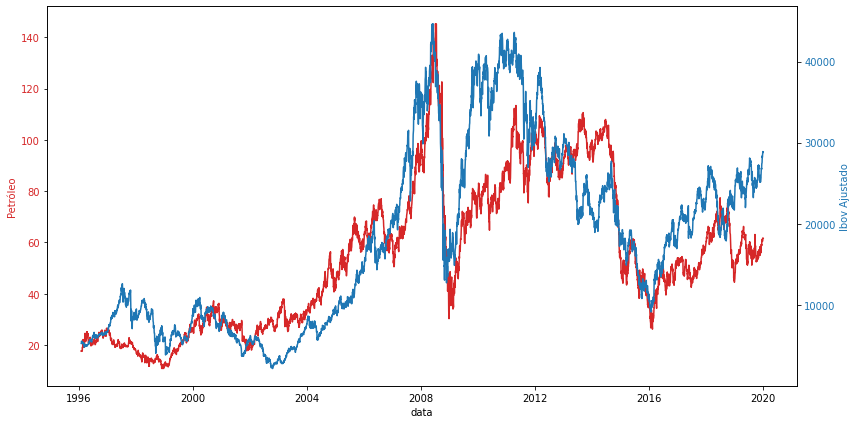

In [4]:
# Visualizando os dados

data1 = df_a.X
data2 = df_a.Y
data3 = df_a.index

fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:red'
ax1.set_xlabel('data')
ax1.set_ylabel('Petróleo', color=color)
ax1.plot(data3, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.set_ylabel('Ibov Ajustado', color=color) 
ax2.plot(data3, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

In [5]:
corr=df_a.corr()
corr

,X,Y
X,1.000000,0.857835
Y,0.857835,1.000000


In [6]:
data1 = df_a.X
data2 = df_a.Y

xbar = np.mean(data1) # cálculo da média de Petróleo
ybar = np.mean(data2)  # cálculo da média de Ibov Dolarizado

a = np.sum(data1*(data2-ybar))/np.sum(data1*(data1-xbar)) #coef. angular estimado
b = ybar - a*xbar #coeficiente linear estimado


yest = a*data1 + b # função estimada

R_squared = np.sum((yest-ybar)**2)/np.sum((data1-ybar)**2) #coef. de determinação

print("R² = ", np.round(R_squared,2))

R² =  0.28


In [7]:
n_obs=15
X_train, X_test = df_a[0:-n_obs], df_a[-n_obs:]
print(X_train.shape, X_test.shape)

(5695, 2) (15, 2)


In [8]:
import statsmodels.tsa.stattools as sts

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Teste de Dickey-Fuller Aumentado:')
print('Serie temporal do Petróleo')
augmented_dickey_fuller_statistics(X_train['X'])
print('Serie temporal do Ibovespa Ajustado')
augmented_dickey_fuller_statistics(X_train['Y'])

#Todos os valores p são maiores que 0,05, rechaçando a hipótese nula de que a série não é estacionária. 

Teste de Dickey-Fuller Aumentado:
Serie temporal do Petróleo
p-value: 0.264343
Serie temporal do Ibovespa Ajustado
p-value: 0.373749


Bressan: A melhor forma para testar estacionariedade usando ADF é começar com uma hipótese de ordem de integração alta, no caso pode ser 2 e rejeitar a hipótese de raiz unitária. Então baixar uma ordem e testar novamente. Até não rejeitar mais H0. A ordem de integração é a última na qual se pode rejeitar H0 no teste ADF. 

Prestar muita atenção que o valor da estatística não está bem definido para valores positivos. Se isso ocorrer, refazer o teste com outro critério para os lags. Eu também incluiria **constante e tendência** no teste, não somente constante, para controlar para tendência determinística. Minha sugestão de implementação do teste seria

In [10]:
def adf_statistics(time_series):
  result = sts.adfuller(time_series.values, regression='ct', autolag='BIC')
  print('adf statistics: %f \n p-value: %f' % (result[0], result[1]))

In [11]:
# Define primeira e segunda diferença 
fd_X_train = X_train - X_train.shift(1)
fd_X_train = fd_X_train.dropna()
sd_X_train = fd_X_train - fd_X_train.shift(1)
sd_X_train = sd_X_train.dropna()

In [12]:
adf_statistics(sd_X_train['X'])

adf statistics: -26.419210 
 p-value: 0.000000


In [13]:
adf_statistics(fd_X_train['X'])

adf statistics: -79.558154 
 p-value: 0.000000


In [14]:
adf_statistics(X_train['X'])

adf statistics: -1.972782 
 p-value: 0.616179


Estatística é negativa, OK e p-valor acima do nível de significância desejado. Portanto, a série é integrada de ordem 1 (pois a primeira diferença foi a última série onde ainda rejeitou-se H0).

Se for fazer cointegração depois, é importante que as duas séries sejam integradas de **mesma ordem**.

In [15]:
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,X,Y
data,,
1996-01-31,0.11,18.937576
1996-02-01,-0.13,121.629001
1996-02-02,0.20,142.986425
1996-02-05,-0.30,-79.730144
1996-02-06,0.21,22.789525


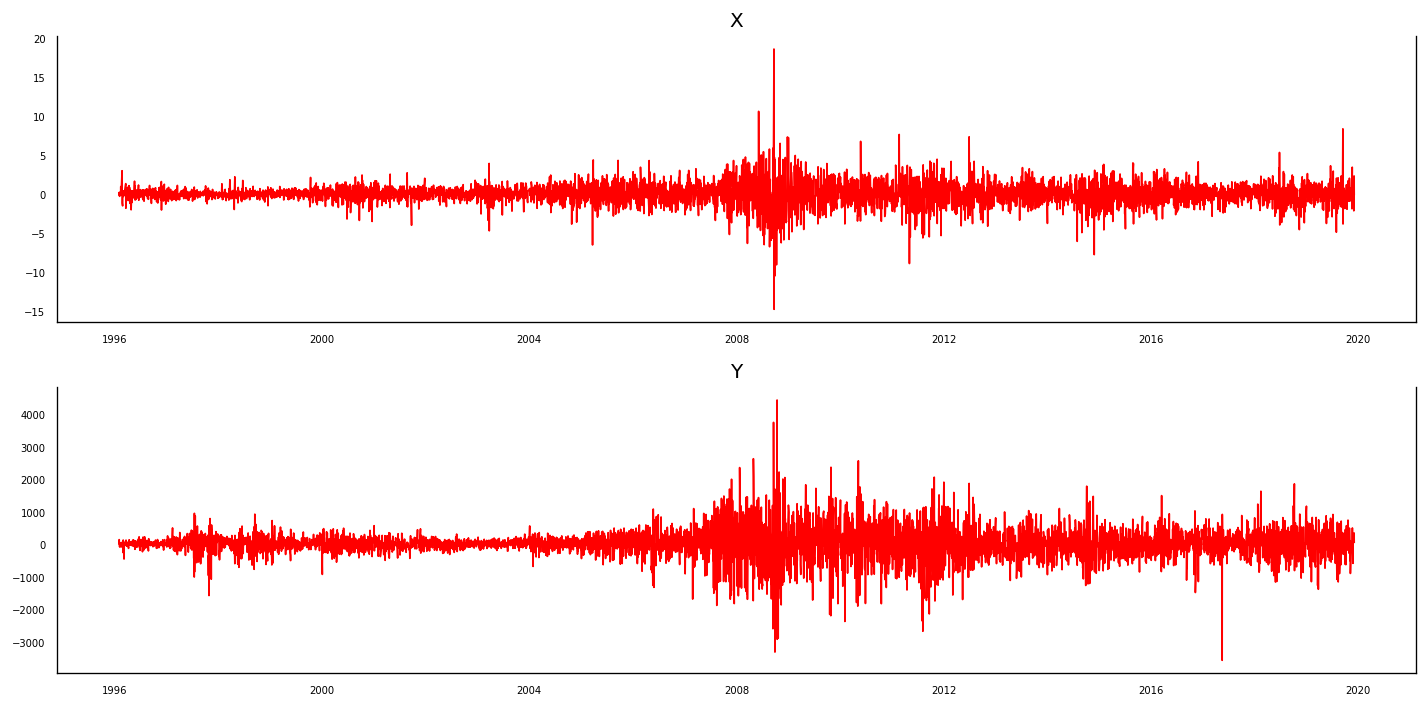

In [16]:
# Desenhando os dados transformados
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
  d = X_train_transformed[X_train_transformed.columns[i]]
  ax.plot(d, color='red', linewidth=1)
  ax.set_title(df_a.columns[i])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  ax.spines['top'].set_alpha(0)
  ax.tick_params(labelsize=6)
  plt.tight_layout();

In [17]:
# Checando se os dados transformados (diferenciados) são estacionários:

print('Test de Dickey-Fuller Aumentado:')
print('Série temporal do Petróleo diferenciada')
augmented_dickey_fuller_statistics(X_train_transformed['X'])
print('Série temporal do Ibovespa Ajustado')
augmented_dickey_fuller_statistics(X_train_transformed['Y'])

# Todos os valores de p são < 0,05, portanto, pode-se concluir que as séries estacionárias são obtidas com uma única ordem de diferenciação.

Test de Dickey-Fuller Aumentado:
Série temporal do Petróleo diferenciada
p-value: 0.000000
Série temporal do Ibovespa Ajustado
p-value: 0.000000


In [18]:
from statsmodels.tsa.api import VAR
model = VAR(X_train_transformed)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [19]:
modelsel=model.select_order(maxlags=15)

In [20]:
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,12.72,12.72,3.352e+05,12.72
1,12.72,12.72*,3.329e+05,12.72*
2,12.72,12.73,3.330e+05,12.72
3,12.72,12.73,3.331e+05,12.72
4,12.72,12.74,3.328e+05,12.72
5,12.71,12.74,3.319e+05,12.72
6,12.71,12.74,3.304e+05,12.72
7,12.71,12.74,3.305e+05,12.72
8,12.71,12.75,3.308e+05,12.72
9,12.71,12.75,3.306e+05,12.72


In [21]:
res = model.fit(maxlags=15, ic='bic')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 13, Apr, 2021
Time:                     23:51:06
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    12.7189
Nobs:                     5693.00    HQIC:                   12.7144
Log likelihood:          -52334.5    FPE:                    331680.
AIC:                      12.7119    Det(Omega_mle):         331331.
--------------------------------------------------------------------
Results for equation X
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.006865         0.017916            0.383           0.702
L1.X         -0.080587         0.014119           -5.708           0.000
L1.Y          0.000231         0.000042            5.487           0.000

Results for equation Y

In [22]:
from statsmodels.tsa.stattools import coint
X = df_a["X"]
y = df_a["Y"]
print('Resultados do Teste de Engle-Granger:')
egtest = coint(y, X, trend='c', method='aeg', autolag='BIC')
egoutput = pd.Series(egtest[0:3], index=['Test Statistic','p-value','Critical Values 1%,5%,10%'])
print (egoutput)

Resultados do Teste de Engle-Granger:
Test Statistic                                                        -3.08664
p-value                                                              0.0910173
Critical Values 1%,5%,10%    [-3.8983593856467347, -3.337200466829654, -3.0...
dtype: object


In [23]:
grangercaus=res.test_causality(['X'],['Y'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
30.11,3.842,0.000,"(1, 11380)"


In [24]:
grangercaus=res.test_causality(['Y'],['X'],kind='f')
grangercaus.summary()


Test statistic,Critical value,p-value,df
4.971,3.842,0.026,"(1, 11380)"


In [25]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=15
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose: 
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,X_x,Y_x
X_y,1.0,0.0
Y_y,0.0,1.0


In [26]:
residuals=res.resid

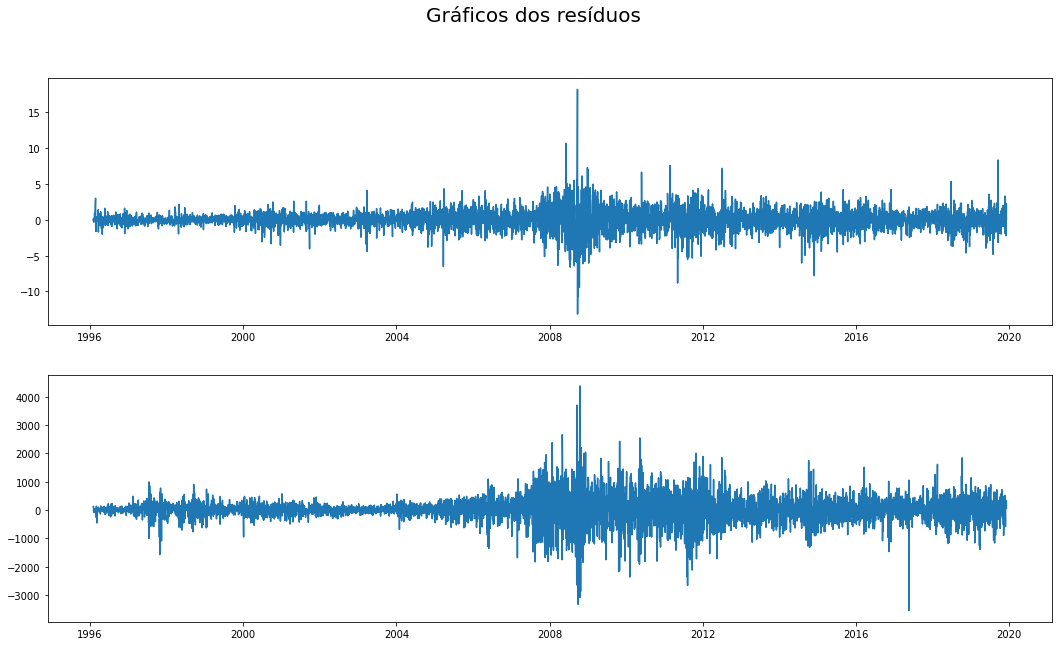

In [27]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos dos resíduos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

In [28]:
print('Petróleo Ibov Ajustado')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

Petróleo Ibov Ajustado


[1.9794896785233756e-21, 3.1477220804363266e-24]

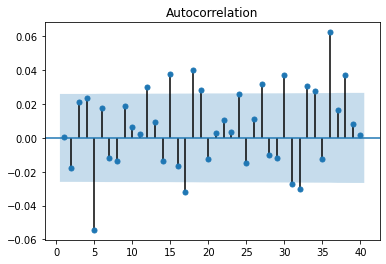

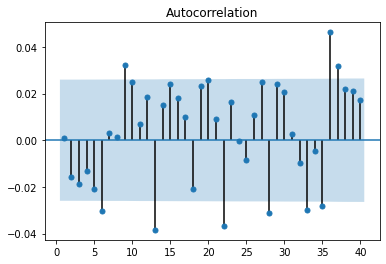

In [29]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 40) for i in range(2)]
plt.show()

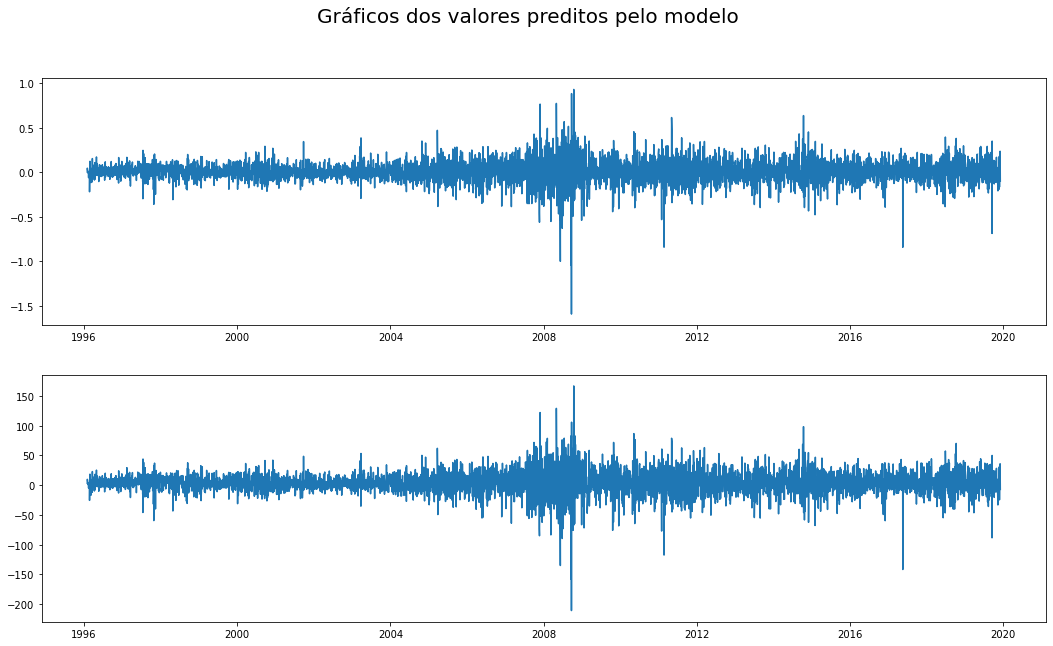

In [30]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos dos valores preditos pelo modelo',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

In [31]:

# Obtendo a ordem do modelo
lag_order = res.k_ar
print('Ordem do modelo:', lag_order)
# Inserindo dados para a previsão (prognósticos)
input_data = X_train_transformed.values[-lag_order:]
# Previsão
pred = res.forecast(y=input_data, steps=n_obs)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Previsões:')
pred

Ordem do modelo: 1
Previsões:


,X_pred,Y_pred
data,,
2019-12-06,0.024001,6.462872
2019-12-09,0.006423,3.642667
2019-12-10,0.007188,3.716612
2019-12-11,0.007143,3.711447
2019-12-12,0.007146,3.711714
2019-12-13,0.007146,3.711699
2019-12-16,0.007146,3.711700
2019-12-17,0.007146,3.711700
2019-12-18,0.007146,3.711700


<Figure size 864x720 with 0 Axes>

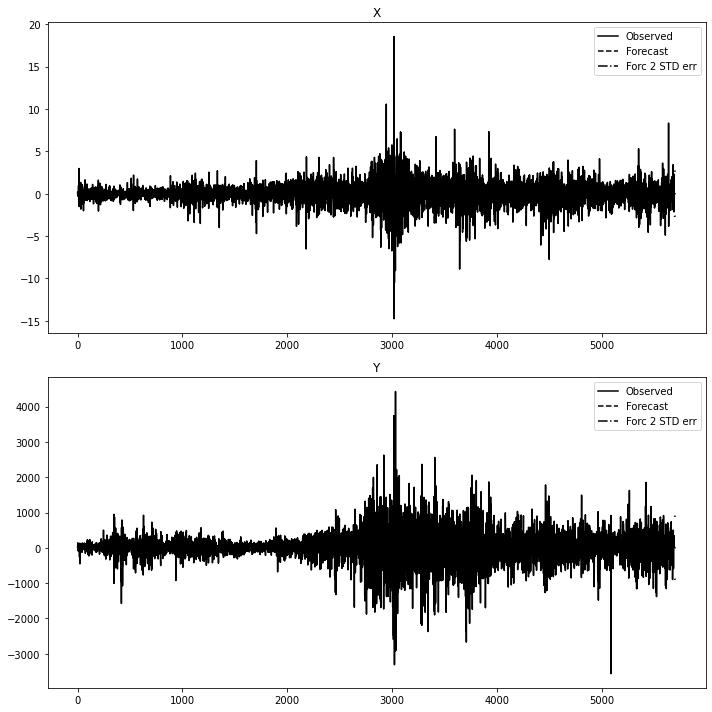

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(15)
plt.tight_layout(h_pad = 1.15)
plt.show()

In [33]:
# Revertendo a transformação
def invert_transformation(X_train, pred):
  forecast = pred.copy()
  columns = X_train.columns
  for col in columns:
    forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
  return forecast

output = invert_transformation(X_train, pred)
output

,X_pred,Y_pred
data,,
2019-12-06,58.444001,26400.335748
2019-12-09,58.450423,26403.978415
2019-12-10,58.457612,26407.695027
2019-12-11,58.464755,26411.406474
2019-12-12,58.471901,26415.118188
2019-12-13,58.479047,26418.829887
2019-12-16,58.486192,26422.541587
2019-12-17,58.493338,26426.253287
2019-12-18,58.500484,26429.964987


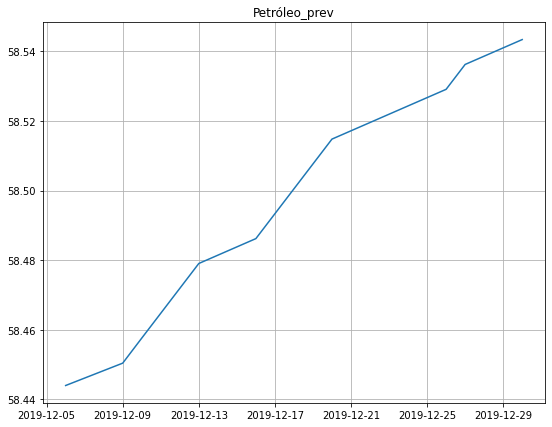

In [34]:
plt.figure(figsize = (9,7))
plt.plot(output.iloc[:,0])
plt.title('Petróleo_prev')
plt.grid()
plt.show()

In [35]:
combine = pd.concat([output['X_pred'], X_test['X']], axis=1)
combine = combine.round(decimals=2)
combine = combine.reset_index()
combine = combine.sort_values(by='data', ascending=False)

In [36]:
combine

,data,X_pred,X
14,2019-12-30,58.54,61.66
13,2019-12-27,58.54,61.76
12,2019-12-26,58.53,61.72
11,2019-12-23,58.52,60.51
10,2019-12-20,58.51,60.43
9,2019-12-19,58.51,61.30
8,2019-12-18,58.50,60.93
7,2019-12-17,58.49,60.88
6,2019-12-16,58.49,60.21
5,2019-12-13,58.48,60.11


In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(combine['X'].values, combine['X_pred'].values))
print('Root mean squared error:', np.sqrt(mean_squared_error(combine['X'].values, combine['X_pred'].values)))

Mean absolute error: 1.8299999999999996
Root mean squared error: 2.0812031776514908
